In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 1. Load the CSV data
df = pd.read_csv("bets.csv")
df = df[df['status'].isin(['win', 'loss'])]
df['ROI'] = df['ROI'].str.rstrip('%').astype('float')
# Filter rows where ROI is 20 or more
df = df[df['ROI'] >= 10]
# Calculate profit based on status and odds
df['profit'] = df.apply(lambda row: row['odds'] - 1 if row['status'] == 'win' else -1, axis=1)
# Once the profit is calculated, you can now calculate the cumulative profit for the bankroll evolution:
df['cumulative_profit'] = df['profit'].cumsum()
# Create a new column 'bet_group' that generalizes bet_line by stripping numbers
df['bet_group'] = df['bet_line'].str.split().str[0]
df.head(2)

,date,league,t1,t2,bet_type,bet_line,ROI,fair_odds,odds,House,url,status,profit,cumulative_profit,bet_group
0,2024-01-20,LOL - LCK Spring,Nongshim RedForce,Gen.G,over,total_dragons 4.5,45.83,1.71,2.50,Bet365,https://www.bet365.com/#/AC/B151/C20930782/D19...,loss,-1.00,-1.00,total_dragons
1,2024-01-20,LOL - LCK Spring,Nongshim RedForce,Gen.G,over,total_towers 10.5,30.83,1.20,1.57,Bet365,https://www.bet365.com/#/AC/B151/C20930782/D19...,win,0.57,-0.43,total_towers


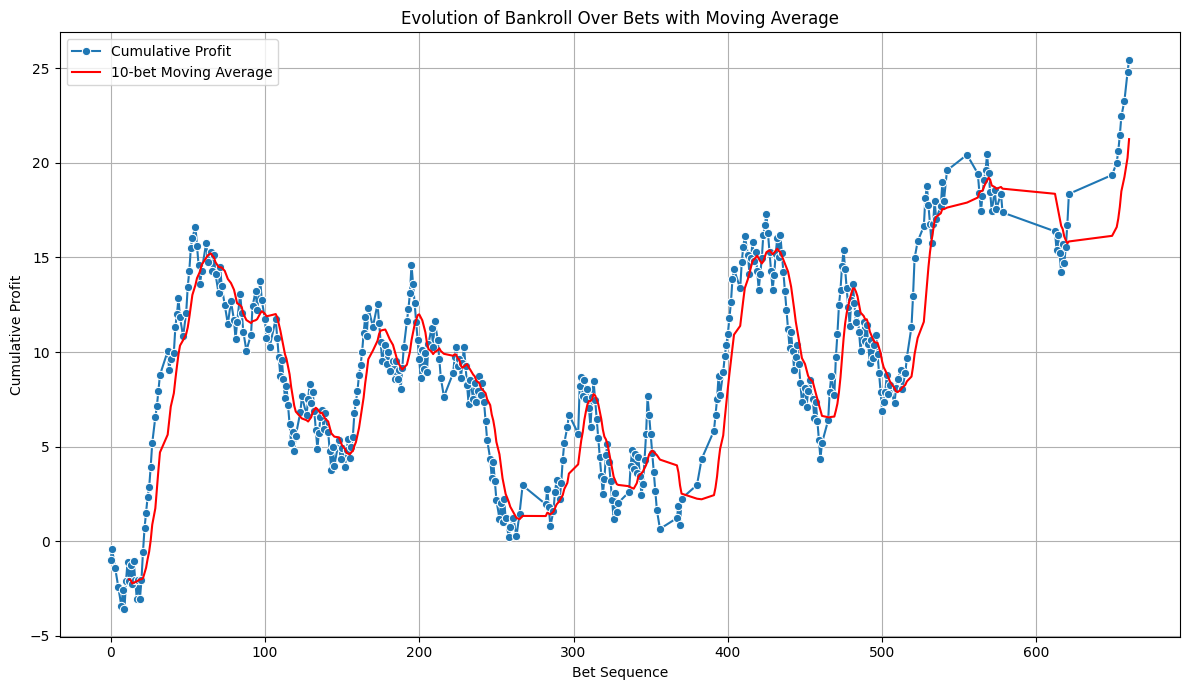

In [3]:
# Calculate the moving average; for instance, over a window of 10 bets
window_size = 10
df['moving_average'] = df['cumulative_profit'].rolling(window=window_size).mean()

plt.figure(figsize=(12, 7))
sns.lineplot(data=df, x=df.index, y='cumulative_profit', marker="o", label='Cumulative Profit')
sns.lineplot(data=df, x=df.index, y='moving_average', color='red', label=f'{window_size}-bet Moving Average')
plt.title('Evolution of Bankroll Over Bets with Moving Average')
plt.ylabel('Cumulative Profit')
plt.xlabel('Bet Sequence')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

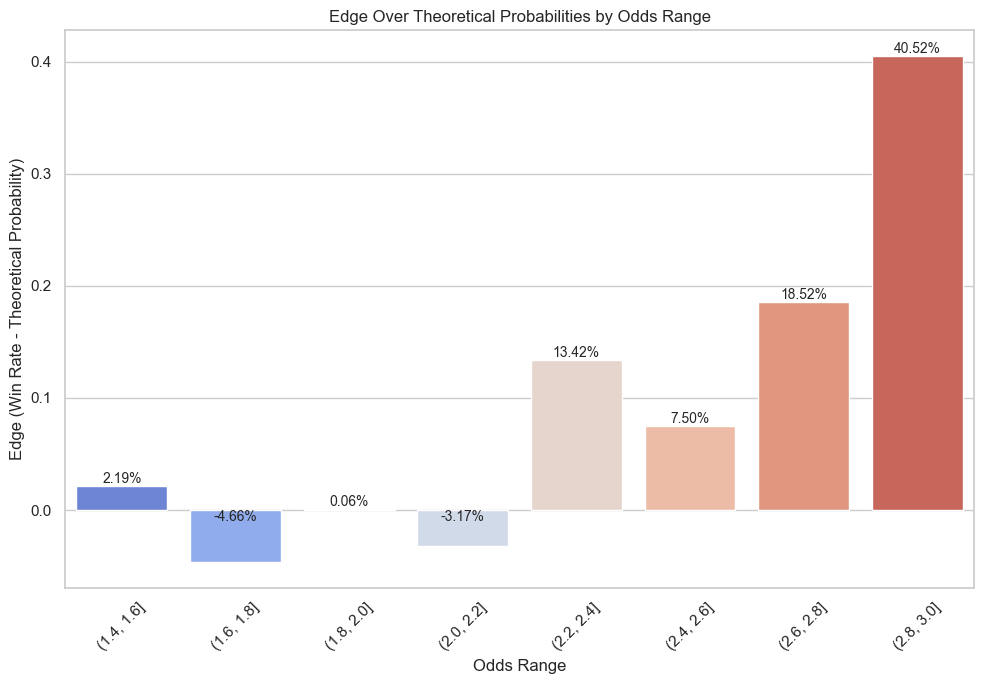

In [4]:
# Define bins for odds
bins = [1.4, 1.6, 1.8, 2, 2.2, 2.4, 2.6, 2.8, 3]
df['odds_bin'] = pd.cut(df['odds'], bins)

# Group by 'odds_bin' and 'status' to get counts of wins and losses for each bin
grouped = df.groupby(['odds_bin', 'status']).size().unstack().fillna(0)

# Calculate theoretical probabilities based on mid-point of odds bins
mid_points = [(b + bins[i+1]) / 2 for i, b in enumerate(bins[:-1])]
theoretical_probs = [1 / point for point in mid_points]

grouped['total'] = grouped['win'] + grouped['loss']
grouped['win_ratio'] = grouped['win'] / grouped['total']
grouped['edge'] = grouped['win_ratio'] - theoretical_probs

# Set the aesthetics
sns.set(style="whitegrid")

# Plot
plt.figure(figsize=(10, 7))
ax = sns.barplot(x=grouped.index, y=grouped['edge'], palette="coolwarm", errorbar=None)

# Adding the edges as text on each bar
for i, value in enumerate(grouped['edge']):
    ax.text(i, value if value > 0 else 0, f'{value:.2%}', 
            ha='center', va='bottom' if value > 0 else 'top', fontsize=10)

# Set the title and labels
plt.title('Edge Over Theoretical Probabilities by Odds Range')
plt.ylabel('Edge (Win Rate - Theoretical Probability)')
plt.xlabel('Odds Range')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [5]:
# 2. Calculate and print the winning rate
win_rate = df[df['status'] == 'win'].shape[0] / df.shape[0] * 100
print(f"Winning Rate: {win_rate:.2f}%")

Winning Rate: 54.50%


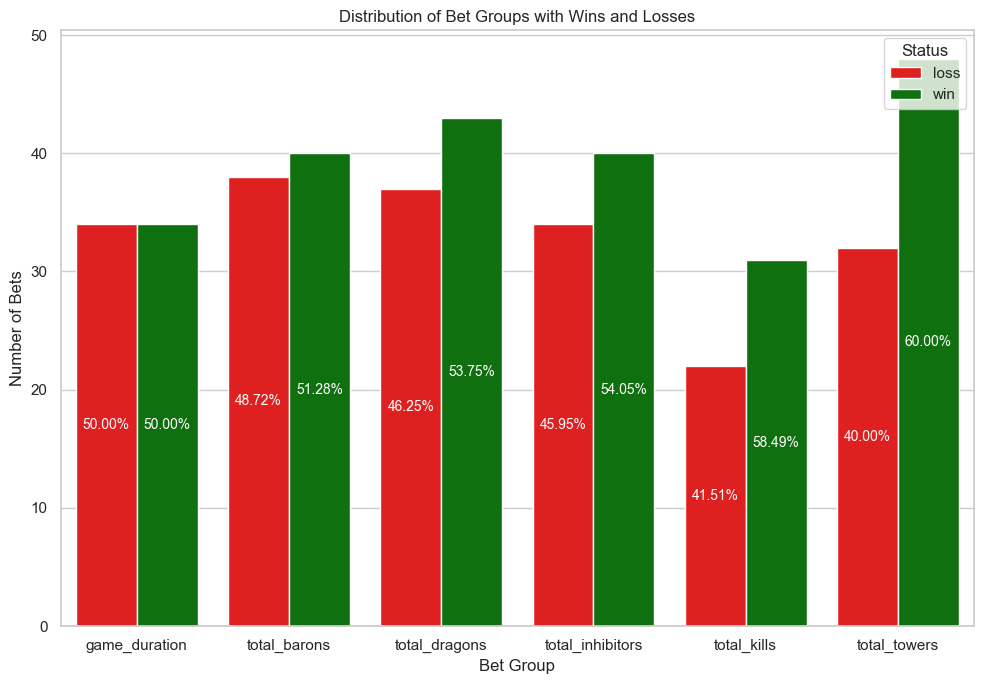

In [6]:
# Group by 'bet_group' and 'status' to get counts of wins and losses for each bet group
grouped = df.groupby(['bet_group', 'status']).size().unstack().fillna(0)
grouped['total'] = grouped['win'] + grouped['loss']
grouped['win_ratio'] = grouped['win'] / grouped['total']
grouped['loss_ratio'] = grouped['loss'] / grouped['total']

# Set the aesthetics
sns.set(style="whitegrid")

# Prepare data for seaborn
grouped['bet_group'] = grouped.index  # make an explicit column for bet_group

# Create the bar plot with win and loss
plt.figure(figsize=(10, 7))
ax = sns.barplot(data=grouped.melt(id_vars=['bet_group', 'win_ratio', 'loss_ratio'], value_vars=['win', 'loss'], 
                                   var_name='status', value_name='count'),
                x='bet_group', y='count', hue='status', hue_order=['loss', 'win'], palette={"win": "green", "loss": "red"})

# Adding the win and loss ratios as text on each bar
for i, bar in enumerate(ax.patches):
    # Display win ratios on "win" bars
    if i >= len(grouped):
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width() / 2.0,
                    height / 2,  # Position the text at half the height of the bar
                    f'{grouped["win_ratio"].iloc[i - len(grouped)]:.2%}',
                    ha='center', va='center',
                    color='white', fontsize=10)
    # Display loss ratios on "loss" bars
    else:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width() / 2.0,
                    height / 2,  # Position the text at half the height of the bar
                    f'{grouped["loss_ratio"].iloc[i]:.2%}',
                    ha='center', va='center',
                    color='white', fontsize=10)

# Set the title and labels
plt.title('Distribution of Bet Groups with Wins and Losses')
plt.ylabel('Number of Bets')
plt.xlabel('Bet Group')
plt.legend(title='Status', loc='upper right')

plt.tight_layout()
plt.show()

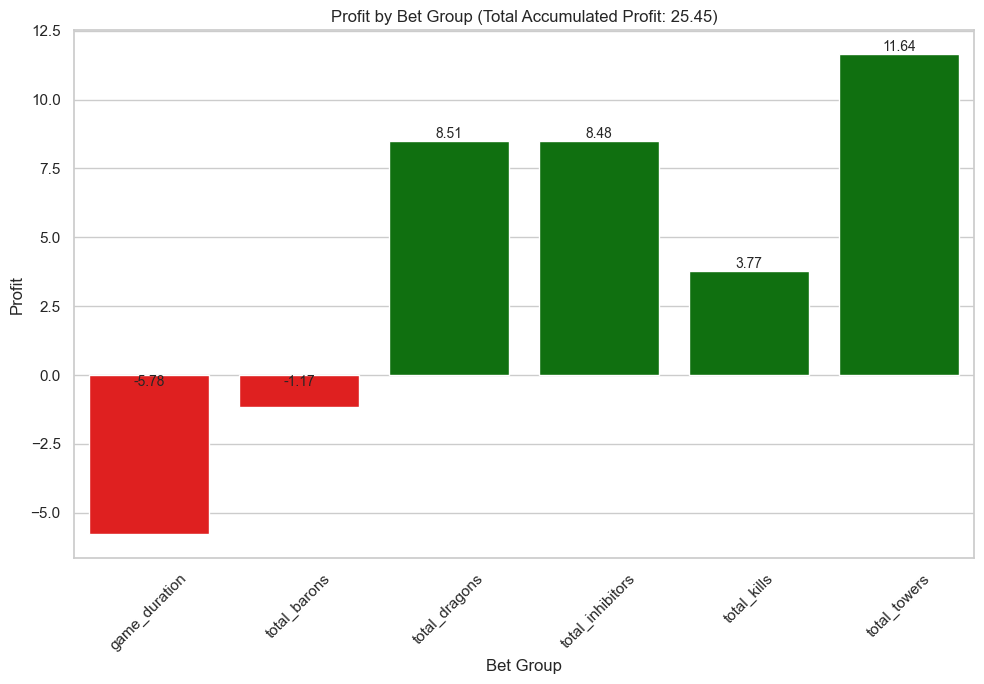

In [7]:
# Calculate the profit for each row based on your criteria
df['profit'] = df.apply(lambda row: row['odds'] - 1 if row['status'] == 'win' else -1, axis=1)

# Aggregate the profit by 'bet_group'
profit_by_group = df.groupby('bet_group')['profit'].sum()

# Calculate total accumulated profit
total_profit = profit_by_group.sum()

# Set the aesthetics
sns.set(style="whitegrid")

# Define colors based on profit values
colors = ['green' if x > 0 else 'red' for x in profit_by_group]

# Plot
plt.figure(figsize=(10, 7))
ax = sns.barplot(x=profit_by_group.index, y=profit_by_group.values, palette=colors)
ax.set_title(f'Profit by Bet Group (Total Accumulated Profit: {total_profit:.2f})')
ax.set_ylabel('Profit')
ax.set_xlabel('Bet Group')
plt.xticks(rotation=45)

for i, value in enumerate(profit_by_group):
    ax.text(i, value if value > 0 else 0, f'{value:.2f}', ha='center', va='bottom' if value > 0 else 'top', fontsize=10)

plt.tight_layout()
plt.show()

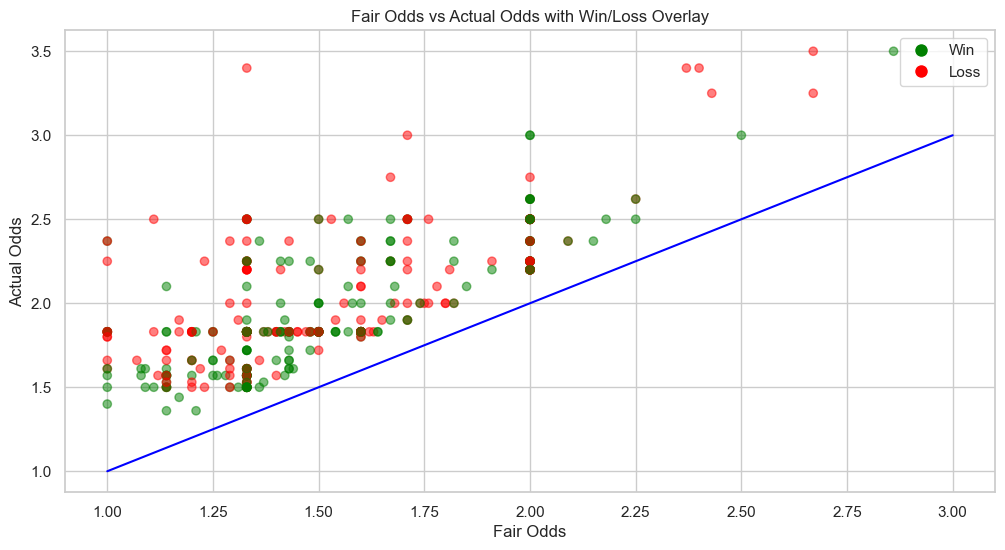

In [8]:
# Color-coding based on status
colors = df['status'].map({'win': 'green', 'loss': 'red'})

plt.figure(figsize=(12, 6))
plt.scatter(df['fair_odds'], df['odds'], alpha=0.5, c=colors)
plt.title('Fair Odds vs Actual Odds with Win/Loss Overlay')
plt.xlabel('Fair Odds')
plt.ylabel('Actual Odds')
plt.plot([1, 3], [1, 3], color='blue')  # y=x line for reference

# Adding a custom legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Win', markersize=10, markerfacecolor='green'),
                   Line2D([0], [0], marker='o', color='w', label='Loss', markersize=10, markerfacecolor='red')]
plt.legend(handles=legend_elements)

plt.show()
